In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Set root paths
ROOT_PATH = os.path.abspath("..")  
MODEL_PATH = os.path.join(ROOT_PATH, "models")
DATA_PATH = os.path.join(ROOT_PATH, "data")
IMG_SIZE = (160, 160)

print("Project root:", ROOT_PATH)
print("Model path:", MODEL_PATH)

Project root: d:\apply_ML\facial_recognition
Model path: d:\apply_ML\facial_recognition\models


In [11]:
# Custom triplet loss for loading
def triplet_loss(y_true, y_pred, alpha=0.2):
    total_len = y_pred.shape[-1] // 3
    a, p, n = y_pred[:, :total_len], y_pred[:, total_len:2*total_len], y_pred[:, 2*total_len:]
    pos_dist = tf.reduce_sum(tf.square(a - p), axis=1)
    neg_dist = tf.reduce_sum(tf.square(a - n), axis=1)
    return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + alpha, 0.0))

# Load models
softmax_model = tf.keras.models.load_model(os.path.join(MODEL_PATH, "softmax_model.keras"))
embedding_model = tf.keras.models.load_model(os.path.join(MODEL_PATH, "embedding_model.keras"))
triplet_model = tf.keras.models.load_model(
    os.path.join(MODEL_PATH, "triplet_model.keras"),
    custom_objects={'triplet_loss': triplet_loss}
)

# Build embedding extractor for triplet model - Fixed version
# The triplet model has a shared embedding base that processes each input
# We need to extract that shared base layer, not use the concatenated output
print("Triplet model summary:")
print(f"Input layers: {len(triplet_model.input)}")
print(f"Output shape: {triplet_model.output.shape}")

# Find the shared embedding layer (usually a nested model)
# The triplet model structure is typically: [base_model(anchor), base_model(positive), base_model(negative)]
# We need to get the base_model
for layer in triplet_model.layers:
    if isinstance(layer, tf.keras.Model) and 'embedding' in layer.name.lower():
        triplet_embed = layer
        break
else:
    # If no embedding model found, create from the first functional layer
    # Assuming the architecture has a shared base
    triplet_embed = None
    for layer in triplet_model.layers:
        if isinstance(layer, tf.keras.Model):
            triplet_embed = layer
            break
    
    # If still None, we need to build it from scratch
    if triplet_embed is None:
        # The embedding model should already work for single images
        # Use the same architecture as embedding_model
        triplet_embed = embedding_model

print("Embedding extractor ready")
print(f"Embedding output shape: {triplet_embed.output.shape}")

Triplet model summary:
Input layers: 3
Output shape: (None, 3840)
Embedding extractor ready
Embedding output shape: (None, 1280)


d:\apply_ML\facial_recognition\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 148 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
def preprocess(path):
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img)/255.
    return np.expand_dims(arr, axis=0)

def cosine_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def embed_softmax(path):
    return embedding_model.predict(preprocess(path), verbose=0).squeeze()

def embed_triplet(path):
    return triplet_embed.predict(preprocess(path), verbose=0).squeeze()

In [13]:
pairs_path = os.path.join(DATA_PATH, "verification_pairs_val.txt")
pairs = pd.read_csv(pairs_path, sep=" ", header=None, names=["img1","img2","label"])
print("Loaded pairs:", len(pairs))

Loaded pairs: 8805


In [14]:
def evaluate_model(name, embed_func):
    scores, labels = [], []
    for _, r in pairs.iterrows():
        img1 = os.path.join(DATA_PATH, r.img1)
        img2 = os.path.join(DATA_PATH, r.img2)
        emb1, emb2 = embed_func(img1), embed_func(img2)
        sim = cosine_sim(emb1, emb2)
        scores.append(sim)
        labels.append(r.label)
    auc = roc_auc_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    print(f"AUC ({name}): {auc:.4f}")
    return fpr, tpr, auc

# Run evaluations
fpr_soft, tpr_soft, auc_soft = evaluate_model("Softmax", embed_softmax)
fpr_trip, tpr_trip, auc_trip = evaluate_model("Triplet", embed_triplet)

AUC (Softmax): 0.6596
AUC (Triplet): 0.6596


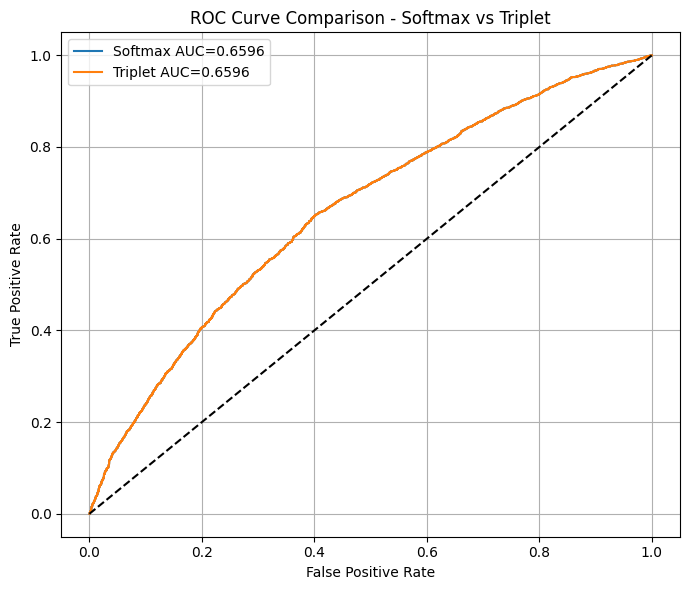


Comparison Summary:
Softmax AUC : 0.6596
Triplet AUC : 0.6596
Plot saved → d:\apply_ML\facial_recognition\output\comparison_roc.png


In [15]:
plt.figure(figsize=(7,6))
plt.plot(fpr_soft, tpr_soft, label=f"Softmax AUC={auc_soft:.4f}")
plt.plot(fpr_trip, tpr_trip, label=f"Triplet AUC={auc_trip:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Softmax vs Triplet")
plt.legend()
plt.grid(True)
plt.tight_layout()

output_plot = os.path.join(ROOT_PATH, "output", "comparison_roc.png")
plt.savefig(output_plot)
plt.show()

print("\nComparison Summary:")
print(f"Softmax AUC : {auc_soft:.4f}")
print(f"Triplet AUC : {auc_trip:.4f}")
print(f"Plot saved → {output_plot}")